# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/kimmypracha/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./data/train.npz')
train_data = train_npz['data']
test_npz  = np.load('./data/test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [6]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

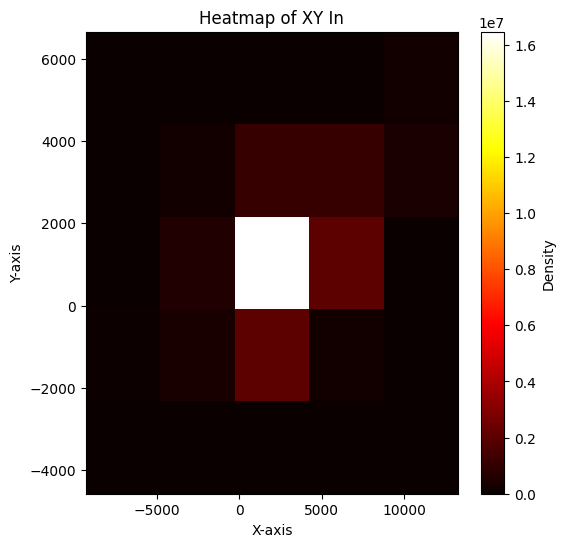

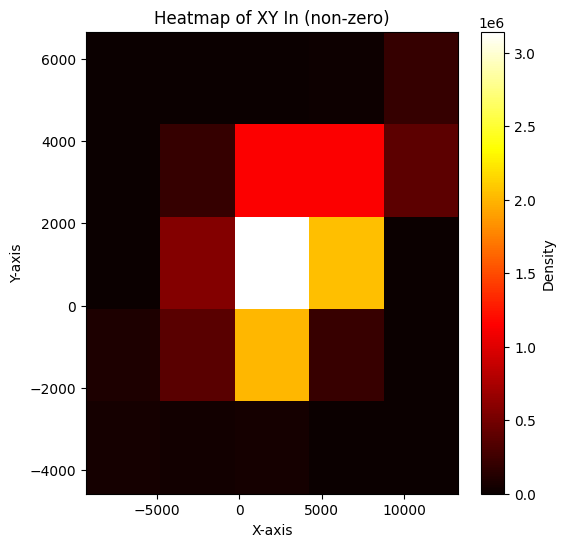

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

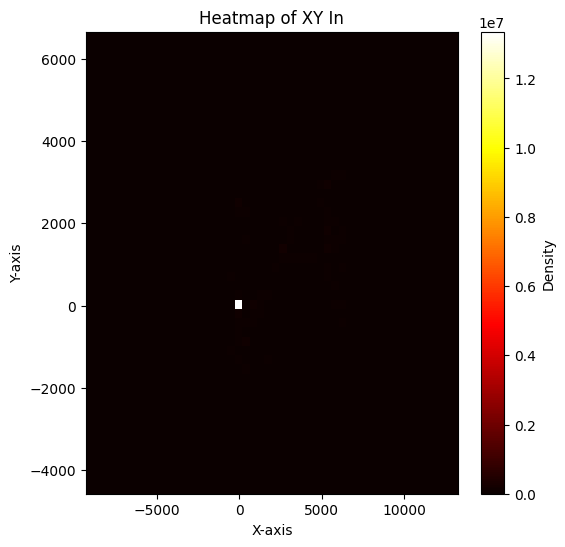

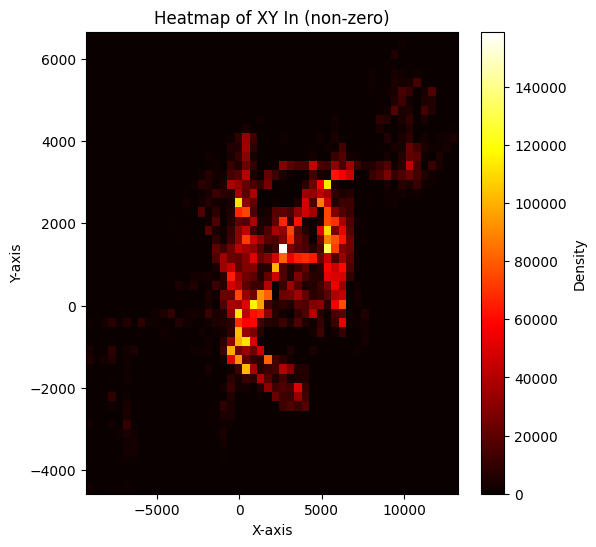

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

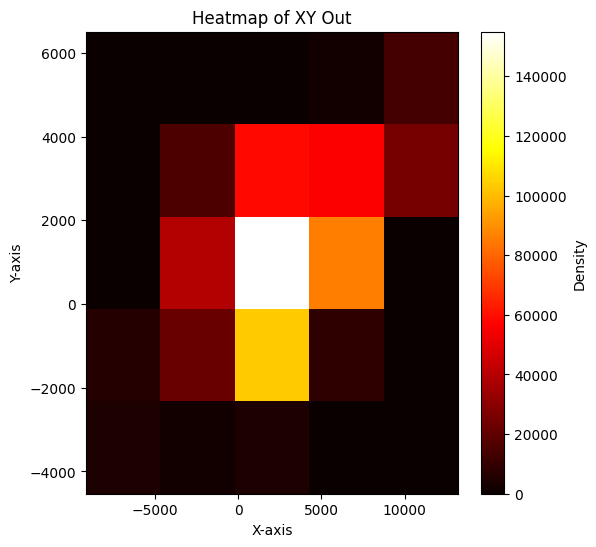

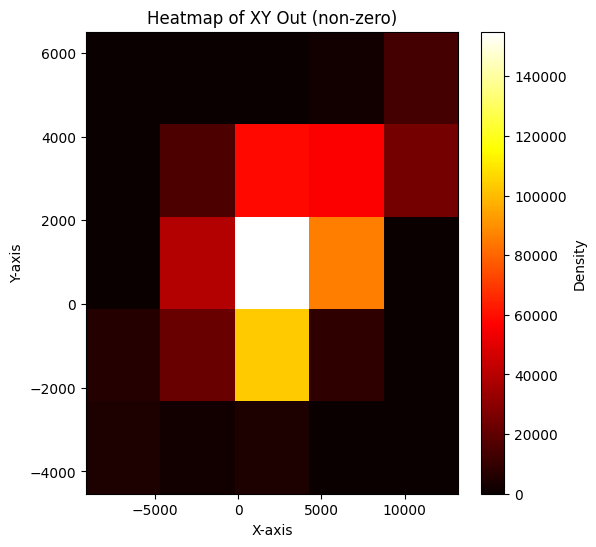

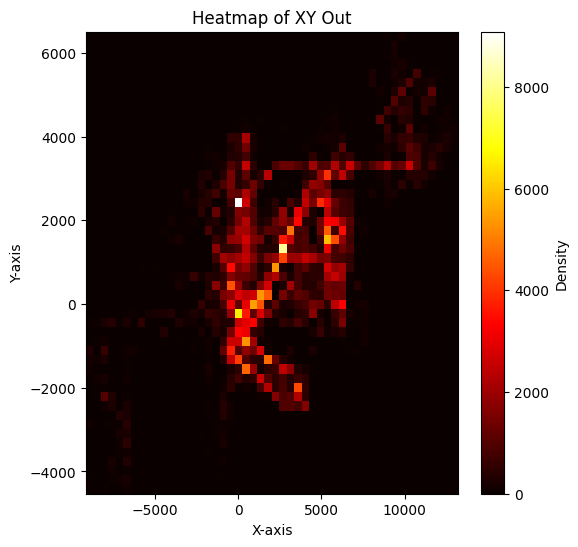

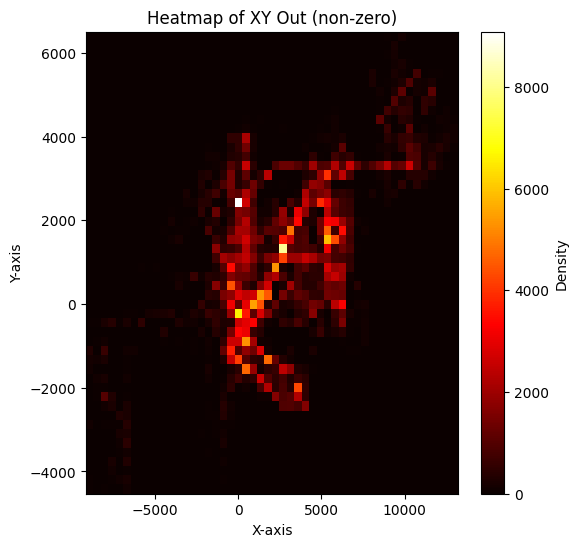

In [21]:
xy_out = train_data[:, 0, 50:, :2].reshape(-1, 2)
xy_out_not_0 = xy_out[(xy_out[:, 0] != 0) & (xy_out[:, 1] != 0)]
plot_heatmap(xy_out, title='Heatmap of XY Out', bins=5)
plot_heatmap(xy_out_not_0, title='Heatmap of XY Out (non-zero)', bins=5)
plot_heatmap(xy_out, title='Heatmap of XY Out', bins=50)
plot_heatmap(xy_out_not_0, title='Heatmap of XY Out (non-zero)', bins=50)

## Step 3: Setting up the Training and Testing

### Example Code:

In [5]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [50]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))


# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [14]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        # x = x[:, :, :, :6] # (batch, 50, 50, 6)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

In [31]:
class CNN(nn.Module):
    def __init__(self, input_channels=6, output_channels=2):
        super(CNN, self).__init__()
        
        # Define the layers
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Linear(512, output_channels * 60)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6) # (batch, 50, 50, 6)
        x = x.permute(0, 3, 1, 2)
        x = self.model(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [47]:
model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = CNN().to(device)
# model = LSTM().to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_32881/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_32881/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:04<07:11,  4.36s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE 31441.7470 | val normalized MSE 52056.4734, | val MAE 980.4950 | val MSE 2550767.2305


Epoch:   2%|▏         | 2/100 [00:07<06:15,  3.84s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE 25331.2445 | val normalized MSE 60774.6462, | val MAE 1032.2697 | val MSE 2977957.6367


Epoch:   3%|▎         | 3/100 [00:11<06:08,  3.79s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE 25535.8363 | val normalized MSE 21902.8039, | val MAE 604.3749 | val MSE 1073237.3799


Epoch:   4%|▍         | 4/100 [00:15<05:59,  3.75s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE 21482.0504 | val normalized MSE 37622.6064, | val MAE 849.9290 | val MSE 1843507.7070


Epoch:   5%|▌         | 5/100 [00:18<05:45,  3.64s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE 23065.7738 | val normalized MSE 71581.7632, | val MAE 926.8110 | val MSE 3507506.3379


Epoch:   6%|▌         | 6/100 [00:22<05:35,  3.57s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE 21076.3374 | val normalized MSE 14646.4456, | val MAE 515.8167 | val MSE 717675.8340


Epoch:   7%|▋         | 7/100 [00:25<05:27,  3.52s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE 21019.6187 | val normalized MSE 17264.9971, | val MAE 570.4886 | val MSE 845984.8564


Epoch:   8%|▊         | 8/100 [00:29<05:22,  3.50s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE 21142.3361 | val normalized MSE 22833.3954, | val MAE 639.6906 | val MSE 1118836.3574


Epoch:   9%|▉         | 9/100 [00:32<05:17,  3.49s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE 20720.0423 | val normalized MSE 13495.3820, | val MAE 477.2194 | val MSE 661273.7134


Epoch:  10%|█         | 10/100 [00:35<05:11,  3.46s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE 22274.0314 | val normalized MSE 21561.6626, | val MAE 598.7404 | val MSE 1056521.4585


Epoch:  11%|█         | 11/100 [00:39<05:05,  3.43s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE 22460.4366 | val normalized MSE 16329.6478, | val MAE 560.5034 | val MSE 800152.7334


Epoch:  12%|█▏        | 12/100 [00:42<05:04,  3.46s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE 20310.2930 | val normalized MSE 30557.0865, | val MAE 666.6156 | val MSE 1497297.2305


Epoch:  13%|█▎        | 13/100 [00:46<04:55,  3.39s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE 20707.3185 | val normalized MSE 20692.1304, | val MAE 576.3328 | val MSE 1013914.3857


Epoch:  14%|█▍        | 14/100 [00:49<04:47,  3.34s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE 20181.8492 | val normalized MSE 32195.4016, | val MAE 755.5325 | val MSE 1577574.6504


Epoch:  15%|█▌        | 15/100 [00:52<04:46,  3.37s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE 19722.5799 | val normalized MSE 24980.5179, | val MAE 651.7712 | val MSE 1224045.3936


Epoch:  16%|█▌        | 16/100 [00:56<04:45,  3.40s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE 19602.2152 | val normalized MSE 13092.4167, | val MAE 474.2074 | val MSE 641528.4312


Epoch:  17%|█▋        | 17/100 [00:59<04:50,  3.50s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE 21974.8626 | val normalized MSE 13284.1089, | val MAE 510.5778 | val MSE 650921.3408


Epoch:  18%|█▊        | 18/100 [01:03<04:48,  3.52s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE 21479.0553 | val normalized MSE 21317.3499, | val MAE 576.3723 | val MSE 1044550.1348


Epoch:  19%|█▉        | 19/100 [01:06<04:39,  3.46s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE 25392.3936 | val normalized MSE 22586.7135, | val MAE 608.9404 | val MSE 1106748.9551


Epoch:  20%|██        | 20/100 [01:10<04:37,  3.47s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE 21602.8072 | val normalized MSE 19262.2561, | val MAE 547.5152 | val MSE 943850.5508


Epoch:  21%|██        | 21/100 [01:13<04:38,  3.52s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE 4233.2794 | val normalized MSE 2342.7961, | val MAE 212.1702 | val MSE 114797.0071


Epoch:  22%|██▏       | 22/100 [01:17<04:33,  3.51s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE 2512.8634 | val normalized MSE 2325.4818, | val MAE 208.5987 | val MSE 113948.6094


Epoch:  23%|██▎       | 23/100 [01:20<04:28,  3.48s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE 2055.9756 | val normalized MSE 1891.9778, | val MAE 190.6576 | val MSE 92706.9116


Epoch:  24%|██▍       | 24/100 [01:24<04:21,  3.45s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE 2045.4382 | val normalized MSE 1757.0652, | val MAE 172.2346 | val MSE 86096.1962


Epoch:  25%|██▌       | 25/100 [01:27<04:20,  3.47s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE 1694.6277 | val normalized MSE 2164.3838, | val MAE 205.0987 | val MSE 106054.8094


Epoch:  26%|██▌       | 26/100 [01:31<04:19,  3.51s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE 1778.3927 | val normalized MSE 1302.0273, | val MAE 160.8253 | val MSE 63799.3404


Epoch:  27%|██▋       | 27/100 [01:34<04:15,  3.50s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE 1648.1289 | val normalized MSE 1377.0762, | val MAE 150.7113 | val MSE 67476.7358


Epoch:  28%|██▊       | 28/100 [01:38<04:10,  3.48s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE 1609.6554 | val normalized MSE 1685.4385, | val MAE 177.2792 | val MSE 82586.4868


Epoch:  29%|██▉       | 29/100 [01:41<04:10,  3.52s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE 1628.9708 | val normalized MSE 1582.2095, | val MAE 173.7956 | val MSE 77528.2660


Epoch:  30%|███       | 30/100 [01:45<04:12,  3.61s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE 1465.9956 | val normalized MSE 3118.0078, | val MAE 225.1143 | val MSE 152782.3844


Epoch:  31%|███       | 31/100 [01:49<04:08,  3.61s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE 1645.0828 | val normalized MSE 1385.7861, | val MAE 164.0289 | val MSE 67903.5198


Epoch:  32%|███▏      | 32/100 [01:52<04:04,  3.59s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE 1622.0746 | val normalized MSE 1659.4695, | val MAE 174.2756 | val MSE 81314.0072


Epoch:  33%|███▎      | 33/100 [01:56<03:58,  3.56s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE 1575.6206 | val normalized MSE 1479.4322, | val MAE 169.7846 | val MSE 72492.1788


Epoch:  34%|███▍      | 34/100 [01:59<03:54,  3.55s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE 1505.3628 | val normalized MSE 1155.7200, | val MAE 147.3434 | val MSE 56630.2789


Epoch:  35%|███▌      | 35/100 [02:03<03:51,  3.56s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE 1500.2422 | val normalized MSE 1092.4555, | val MAE 140.8154 | val MSE 53530.3199


Epoch:  36%|███▌      | 36/100 [02:06<03:48,  3.58s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE 1589.4133 | val normalized MSE 1695.9759, | val MAE 176.4733 | val MSE 83102.8181


Epoch:  37%|███▋      | 37/100 [02:10<03:47,  3.61s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE 1526.4538 | val normalized MSE 1067.8999, | val MAE 141.2847 | val MSE 52327.0942


Epoch:  38%|███▊      | 38/100 [02:14<03:48,  3.68s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE 1495.0364 | val normalized MSE 1404.2820, | val MAE 161.3184 | val MSE 68809.8181


Epoch:  39%|███▉      | 39/100 [02:18<03:46,  3.71s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE 1564.5976 | val normalized MSE 1068.0918, | val MAE 140.1979 | val MSE 52336.5005


Epoch:  40%|████      | 40/100 [02:21<03:38,  3.64s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE 1564.2125 | val normalized MSE 930.7836, | val MAE 132.1135 | val MSE 45608.3973


Epoch:  41%|████      | 41/100 [02:25<03:32,  3.61s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE 375.5385 | val normalized MSE 315.7676, | val MAE  80.0426 | val MSE 15472.6148


Epoch:  42%|████▏     | 42/100 [02:28<03:25,  3.55s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE 259.3977 | val normalized MSE 281.7785, | val MAE  75.2954 | val MSE 13807.1461


Epoch:  43%|████▎     | 43/100 [02:32<03:18,  3.49s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE 242.9502 | val normalized MSE 354.9536, | val MAE  82.4484 | val MSE 17392.7287


Epoch:  44%|████▍     | 44/100 [02:35<03:13,  3.45s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE 234.9135 | val normalized MSE 272.5115, | val MAE  73.6673 | val MSE 13353.0621


Epoch:  45%|████▌     | 45/100 [02:38<03:08,  3.43s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE 231.5594 | val normalized MSE 224.0144, | val MAE  67.4304 | val MSE 10976.7057


Epoch:  46%|████▌     | 46/100 [02:42<03:08,  3.49s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE 224.3547 | val normalized MSE 239.7175, | val MAE  71.7667 | val MSE 11746.1548


Epoch:  47%|████▋     | 47/100 [02:45<03:03,  3.45s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE 220.4506 | val normalized MSE 245.8556, | val MAE  72.5905 | val MSE 12046.9267


Epoch:  48%|████▊     | 48/100 [02:49<02:56,  3.40s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE 210.8667 | val normalized MSE 267.1127, | val MAE  72.5862 | val MSE 13088.5213


Epoch:  49%|████▉     | 49/100 [02:52<02:53,  3.40s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE 213.4211 | val normalized MSE 256.2096, | val MAE  71.2503 | val MSE 12554.2696


Epoch:  50%|█████     | 50/100 [02:55<02:45,  3.32s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE 211.0998 | val normalized MSE 254.2349, | val MAE  71.5792 | val MSE 12457.5100


Epoch:  51%|█████     | 51/100 [02:58<02:40,  3.27s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE 204.3622 | val normalized MSE 242.1993, | val MAE  68.6346 | val MSE 11867.7654


Epoch:  52%|█████▏    | 52/100 [03:01<02:34,  3.21s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE 195.2769 | val normalized MSE 215.6826, | val MAE  67.0639 | val MSE 10568.4461


Epoch:  53%|█████▎    | 53/100 [03:05<02:30,  3.19s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE 188.4448 | val normalized MSE 225.7015, | val MAE  69.5198 | val MSE 11059.3715


Epoch:  54%|█████▍    | 54/100 [03:08<02:25,  3.17s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE 194.6743 | val normalized MSE 306.3852, | val MAE  77.4137 | val MSE 15012.8758


Epoch:  55%|█████▌    | 55/100 [03:11<02:25,  3.23s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE 184.2953 | val normalized MSE 261.2688, | val MAE  70.8553 | val MSE 12802.1705


Epoch:  56%|█████▌    | 56/100 [03:14<02:23,  3.26s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE 178.4271 | val normalized MSE 254.4298, | val MAE  70.3493 | val MSE 12467.0578


Epoch:  57%|█████▋    | 57/100 [03:17<02:17,  3.20s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE 176.3102 | val normalized MSE 224.9938, | val MAE  66.9218 | val MSE 11024.6980


Epoch:  58%|█████▊    | 58/100 [03:21<02:15,  3.23s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE 201.9909 | val normalized MSE 258.0590, | val MAE  74.5818 | val MSE 12644.8896


Epoch:  59%|█████▉    | 59/100 [03:24<02:11,  3.22s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE 198.2142 | val normalized MSE 229.3515, | val MAE  67.7746 | val MSE 11238.2211


Epoch:  60%|██████    | 60/100 [03:27<02:07,  3.19s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE 182.5285 | val normalized MSE 215.0819, | val MAE  65.3969 | val MSE 10539.0140


Epoch:  61%|██████    | 61/100 [03:30<02:03,  3.17s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE  84.8352 | val normalized MSE 121.0120, | val MAE  49.9391 | val MSE 5929.5882


Epoch:  62%|██████▏   | 62/100 [03:33<01:59,  3.15s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE  77.2322 | val normalized MSE 124.5218, | val MAE  50.2930 | val MSE 6101.5673


Epoch:  63%|██████▎   | 63/100 [03:36<01:56,  3.15s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE  75.7557 | val normalized MSE 121.0122, | val MAE  49.8477 | val MSE 5929.5975


Epoch:  64%|██████▍   | 64/100 [03:40<01:53,  3.15s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE  74.2324 | val normalized MSE 118.6104, | val MAE  49.4894 | val MSE 5811.9084


Epoch:  65%|██████▌   | 65/100 [03:43<01:53,  3.24s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE  71.6367 | val normalized MSE 120.8745, | val MAE  49.7077 | val MSE 5922.8526


Epoch:  66%|██████▌   | 66/100 [03:46<01:49,  3.22s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE  71.3958 | val normalized MSE 109.8642, | val MAE  47.4861 | val MSE 5383.3457


Epoch:  67%|██████▋   | 67/100 [03:49<01:46,  3.22s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE  71.3287 | val normalized MSE 114.2564, | val MAE  48.6271 | val MSE 5598.5656


Epoch:  68%|██████▊   | 68/100 [03:52<01:41,  3.18s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE  69.6680 | val normalized MSE 121.9373, | val MAE  49.6976 | val MSE 5974.9276


Epoch:  69%|██████▉   | 69/100 [03:56<01:37,  3.15s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE  68.7274 | val normalized MSE 113.8471, | val MAE  48.4749 | val MSE 5578.5062


Epoch:  70%|███████   | 70/100 [03:59<01:34,  3.16s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE  69.1160 | val normalized MSE 118.8251, | val MAE  49.0044 | val MSE 5822.4322


Epoch:  71%|███████   | 71/100 [04:02<01:31,  3.17s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE  69.2725 | val normalized MSE 111.7323, | val MAE  47.6501 | val MSE 5474.8820


Epoch:  72%|███████▏  | 72/100 [04:05<01:27,  3.13s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE  67.3338 | val normalized MSE 110.8924, | val MAE  47.7647 | val MSE 5433.7300


Epoch:  73%|███████▎  | 73/100 [04:08<01:25,  3.15s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE  66.5838 | val normalized MSE 112.6010, | val MAE  48.0772 | val MSE 5517.4486


Epoch:  74%|███████▍  | 74/100 [04:12<01:23,  3.22s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE  67.6502 | val normalized MSE 117.1919, | val MAE  48.7788 | val MSE 5742.4012


Epoch:  75%|███████▌  | 75/100 [04:15<01:21,  3.27s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE  65.4043 | val normalized MSE 109.6873, | val MAE  47.2856 | val MSE 5374.6783


Epoch:  76%|███████▌  | 76/100 [04:18<01:18,  3.26s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE  65.5849 | val normalized MSE 105.6111, | val MAE  46.5557 | val MSE 5174.9459


Epoch:  77%|███████▋  | 77/100 [04:21<01:14,  3.25s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE  65.7243 | val normalized MSE 109.1231, | val MAE  47.4829 | val MSE 5347.0302


Epoch:  78%|███████▊  | 78/100 [04:25<01:11,  3.25s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE  64.9063 | val normalized MSE 107.5129, | val MAE  47.1642 | val MSE 5268.1339


Epoch:  79%|███████▉  | 79/100 [04:28<01:07,  3.20s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE  63.4022 | val normalized MSE 104.9940, | val MAE  46.2949 | val MSE 5144.7038


Epoch:  80%|████████  | 80/100 [04:31<01:05,  3.28s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE  63.3151 | val normalized MSE 108.5608, | val MAE  47.2249 | val MSE 5319.4791


Epoch:  81%|████████  | 81/100 [04:35<01:03,  3.32s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE  49.9382 | val normalized MSE  92.4169, | val MAE  43.4329 | val MSE 4528.4304


Epoch:  82%|████████▏ | 82/100 [04:38<01:00,  3.36s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE  48.2862 | val normalized MSE  91.3387, | val MAE  43.1147 | val MSE 4475.5968


Epoch:  83%|████████▎ | 83/100 [04:42<00:58,  3.44s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE  47.6439 | val normalized MSE  90.7972, | val MAE  42.9389 | val MSE 4449.0613


Epoch:  84%|████████▍ | 84/100 [04:45<00:55,  3.48s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE  47.4490 | val normalized MSE  91.0489, | val MAE  43.0988 | val MSE 4461.3958


Epoch:  85%|████████▌ | 85/100 [04:49<00:51,  3.46s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE  47.2608 | val normalized MSE  90.4578, | val MAE  42.8675 | val MSE 4432.4314


Epoch:  86%|████████▌ | 86/100 [04:52<00:48,  3.43s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE  47.5157 | val normalized MSE  90.3300, | val MAE  42.9011 | val MSE 4426.1713


Epoch:  87%|████████▋ | 87/100 [04:55<00:44,  3.42s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE  47.1053 | val normalized MSE  90.2305, | val MAE  42.8359 | val MSE 4421.2956


Epoch:  88%|████████▊ | 88/100 [04:59<00:40,  3.41s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE  46.9195 | val normalized MSE  90.4262, | val MAE  42.8970 | val MSE 4430.8813


Epoch:  89%|████████▉ | 89/100 [05:02<00:36,  3.34s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE  46.3363 | val normalized MSE  90.2936, | val MAE  42.8441 | val MSE 4424.3879


Epoch:  90%|█████████ | 90/100 [05:05<00:32,  3.23s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE  46.5474 | val normalized MSE  90.0186, | val MAE  42.7616 | val MSE 4410.9129


Epoch:  91%|█████████ | 91/100 [05:08<00:28,  3.22s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE  46.3494 | val normalized MSE  89.6674, | val MAE  42.7408 | val MSE 4393.7029


Epoch:  92%|█████████▏| 92/100 [05:12<00:26,  3.27s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE  46.3060 | val normalized MSE  89.5499, | val MAE  42.6290 | val MSE 4387.9441


Epoch:  93%|█████████▎| 93/100 [05:15<00:23,  3.29s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE  46.2832 | val normalized MSE  89.3285, | val MAE  42.5732 | val MSE 4377.0941


Epoch:  94%|█████████▍| 94/100 [05:18<00:19,  3.24s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE  46.1030 | val normalized MSE  88.4936, | val MAE  42.3981 | val MSE 4336.1854


Epoch:  95%|█████████▌| 95/100 [05:21<00:16,  3.21s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE  45.7496 | val normalized MSE  89.1051, | val MAE  42.6294 | val MSE 4366.1480


Epoch:  96%|█████████▌| 96/100 [05:24<00:12,  3.19s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE  45.6259 | val normalized MSE  89.9144, | val MAE  42.7087 | val MSE 4405.8044


Epoch:  97%|█████████▋| 97/100 [05:27<00:09,  3.19s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE  45.6348 | val normalized MSE  89.4416, | val MAE  42.5896 | val MSE 4382.6397


Epoch:  98%|█████████▊| 98/100 [05:31<00:06,  3.20s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE  45.4950 | val normalized MSE  88.6544, | val MAE  42.4584 | val MSE 4344.0639


Epoch:  99%|█████████▉| 99/100 [05:34<00:03,  3.19s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE  45.2644 | val normalized MSE  87.7141, | val MAE  42.2481 | val MSE 4297.9927


Epoch: 100%|██████████| 100/100 [05:37<00:00,  3.38s/epoch]

Epoch 099 | Learning rate 0.000001 | train normalized MSE  45.1648 | val normalized MSE  87.6260, | val MAE  42.1705 | val MSE 4293.6733


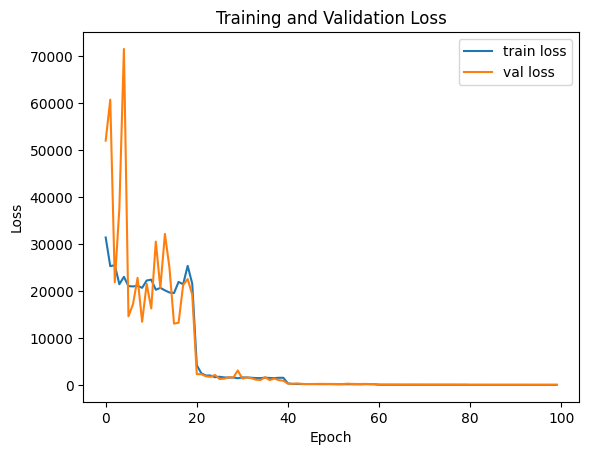

In [48]:
train_losses = []
val_losses = []
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
      
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

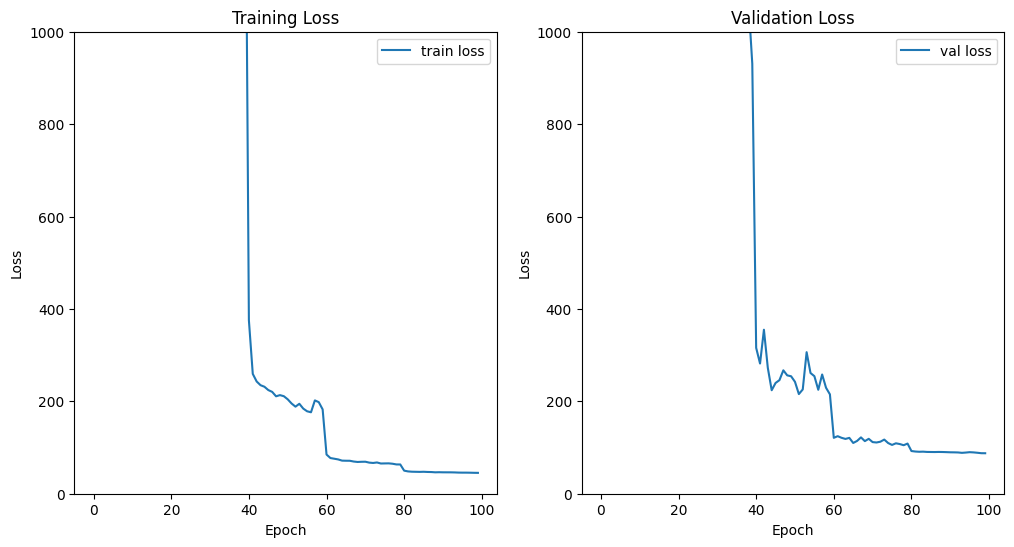

In [49]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(train_losses, label='train loss')    
ax[1].plot(val_losses, label='val loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Validation Loss')
ax[0].set_ylim(0, 1000)
ax[1].set_ylim(0, 1000)
ax[0].legend()
ax[1].legend()
plt.show()

#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [18]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_42403/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


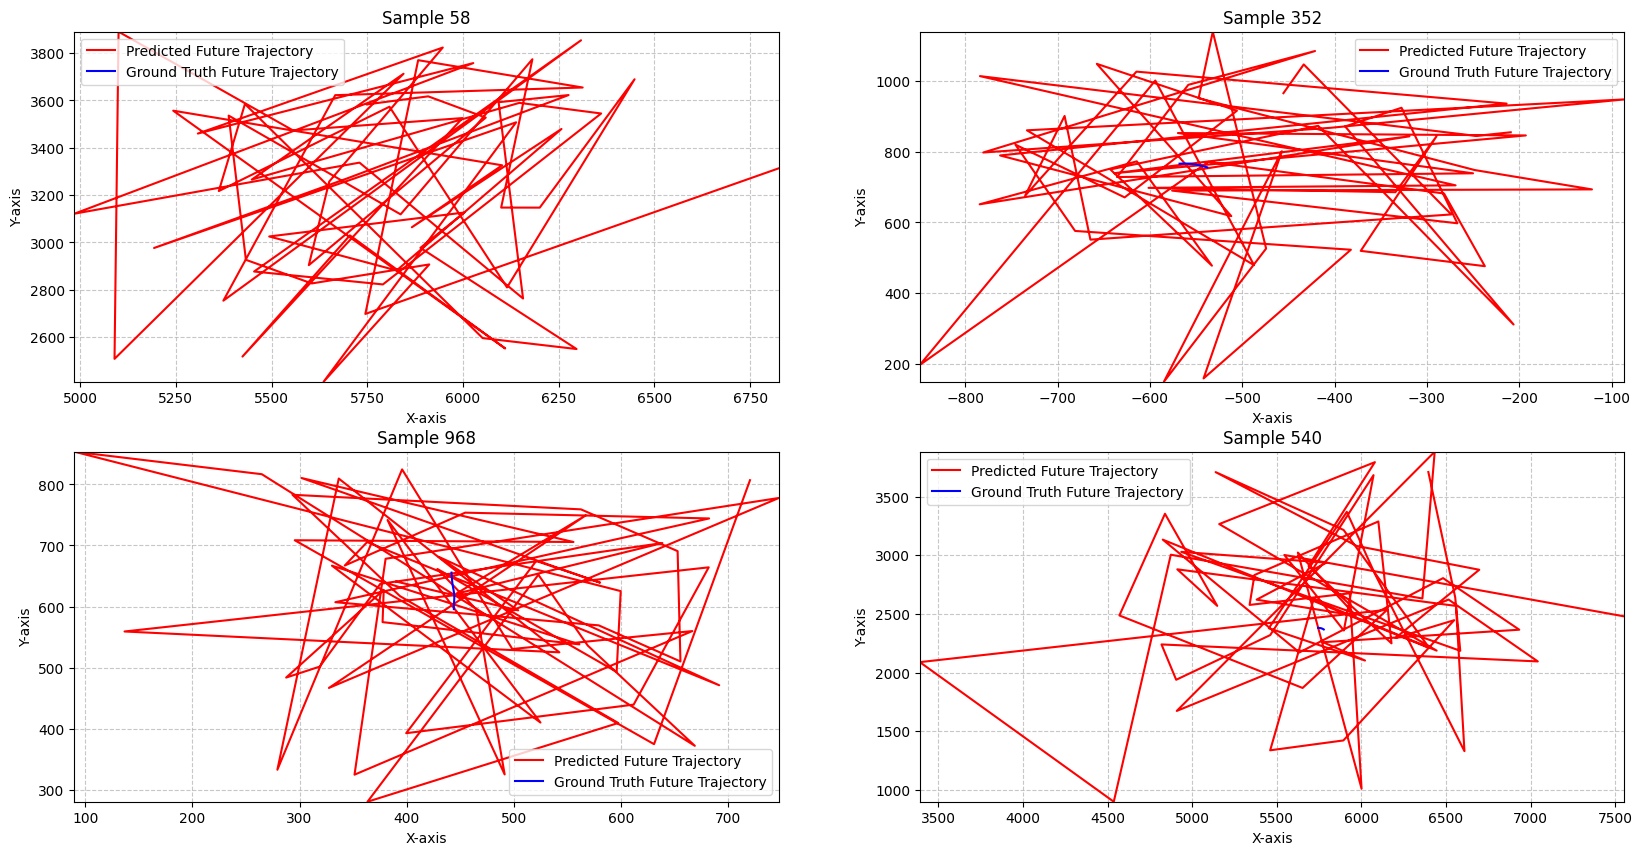

In [19]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [20]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B